<h1> Network Analysis in Python </h1>
Finding a shortest path using a specific street network is a common GIS problem that has many practical applications. For example, navigation, one of those ‘every-day’ applications for which routing algorithms are used to find the optimal route between two or more points.

Of course, the Python ecosystem has produced packages that can be used to conduct network analyses, such as routing. The NetworkX package provides various tools to analyse networks, and implements several different routing algorithms, such as the Dijkstra’s or the A* algorithms. Both are commonly used to find shortest paths along transport networks.

To be able to conduct network analysis, it is, of course, necessary to have a network that is used for the analyses. The OSMnx package enables us to retrieve routable networks from OpenStreetMap for various transport modes (walking, cycling and driving). OSMnx also wraps some of NetworkX’s functionality in a convenient way for using it on OpenStreetMap data.

In the following section, we will use OSMnx to find the shortest path between two points based on cyclable roads. With only the tiniest modifications, we can then repeat the analysis for the walkable street network.

<h1> Obtain a routable network </h1>
To download OpenStreetMap data that represents the street network, we can use it’s graph_from_place() function. As parameters, it expects a place name and, optionally, a network type.

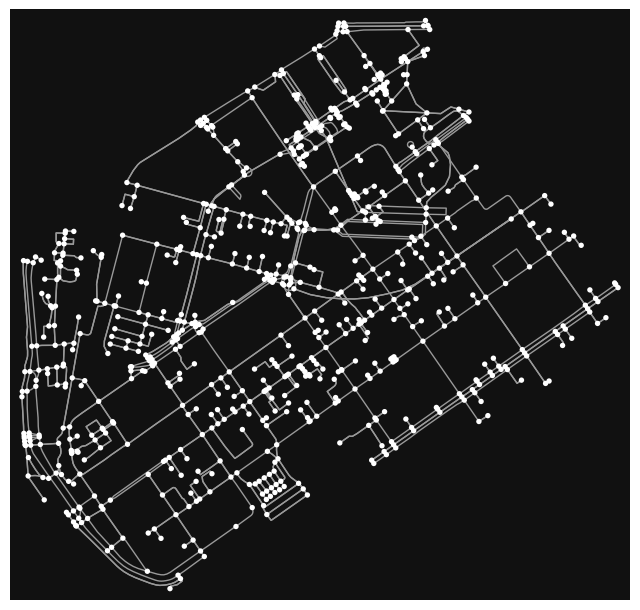

In [1]:
import osmnx

PLACE_NAME = "Kamppi, Helsinki, Finland"
graph = osmnx.graph_from_place(
    PLACE_NAME,
    network_type="bike"
)
figure, ax = osmnx.plot_graph(graph)

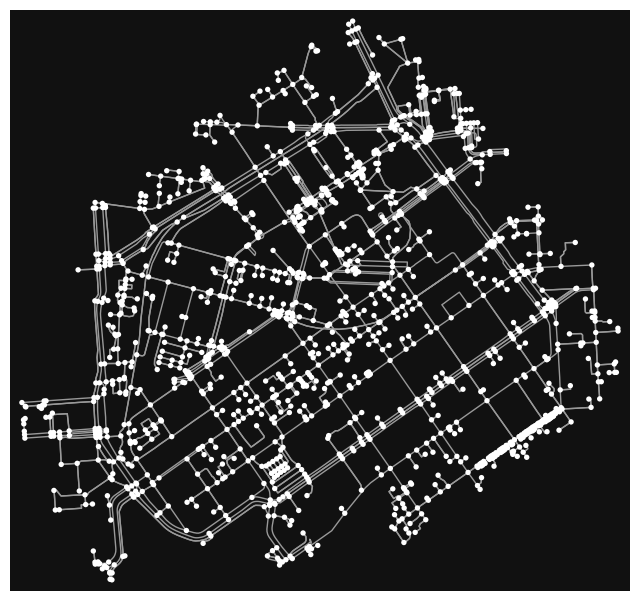

In [2]:
# Get the area of interest polygon
place_polygon = osmnx.geocode_to_gdf(PLACE_NAME)

# Re-project the polygon to a local projected CRS (so that the CRS unit is meters)
place_polygon = place_polygon.to_crs("EPSG:3067")

# Buffer by 200 meters
place_polygon["geometry"] = place_polygon.buffer(200)

# Re-project the polygon back to WGS84 (required by OSMnx)
place_polygon = place_polygon.to_crs("EPSG:4326")

# Retrieve the network graph
graph = osmnx.graph_from_polygon(
    place_polygon.at[0, "geometry"],
    network_type="bike"
)

fig, ax = osmnx.plot_graph(graph)

<h1> Data Overview </h1>
Now that we obtained a complete network graph for the travel mode we specified (cycling), we can take a closer look at which attributes are assigned to the nodes and edges of the network. It is probably easiest to first convert the network into a geo-data frame on which we can then use the tools we learnt in earlier lessons.

To convert a graph into a geo-data frame, we can use osmnx.graph_to_gdfs() (see previous section). Here, we can make use of the function’s parameters nodes and edges to select whether we want only nodes, only edges, or both (the default):

In [3]:
# Retrieve only edges from the graph
edges = osmnx.graph_to_gdfs(graph, nodes=False, edges=True)
edges.head()

osmid  oneway lanes             name  \
u        v          key                                                       
25216594 1372425721 0               23717777    True     2    Porkkalankatu   
         1372425714 0               23856784    True     2   Mechelininkatu   
25238865 146447626  0    [59355210, 4229487]   False     2        Santakatu   
         57661989   0                7842621   False   NaN  Sinikaislankuja   
         314767800  0              231643806   False   NaN              NaN   

                             highway maxspeed reversed  length  \
u        v          key                                          
25216594 1372425721 0        primary       40    False  10.404   
         1372425714 0        primary       40    False  40.885   
25238865 146447626  0    residential       30    False  44.303   
         57661989   0    residential       30     True  76.704   
         314767800  0       cycleway      NaN    False  60.066   

                                                                  geometry  \
u        v          key                                                      
25216594 1372425721 0    LINESTRING (24.92106 60.16479, 24.92087 60.16479)   
         1372425714 0    LINESTRING (24.92106 60.16479, 24.92095 60.164...   
25238865 146447626  0    LINESTRING (24.91994 60.16279, 24.91932 60.162...   
         57661989   0    LINESTRING (24.91994 60.16279, 24.91995 60.162...   
         314767800  0    LINESTRING (24.91994 60.16279, 24.92014 60.162...   

                        junction width access bridge service tunnel  
u        v          key                                              
25216594 1372425721 0        NaN   NaN    NaN    NaN     NaN    NaN  
         1372425714 0        NaN   NaN    NaN    NaN     NaN    NaN  
25238865 146447626  0        NaN   NaN    NaN    NaN     NaN    NaN  
         57661989   0        NaN   NaN    NaN    NaN     NaN    NaN  
         314767800  0        NaN   NaN    NaN    NaN     NaN    NaN

The resulting geo-data frame comprises of a long list of columns. Most of them relate to OpenStreetMap tags, and their names are rather self-explanatory. the columns u and v describe the topological relationship within the network: they denote the start and end node of each edge.

In [4]:
# What types of streets are in the data?
edges["highway"].value_counts()

service                      1037
pedestrian                    542
residential                   481
cycleway                      477
tertiary                      219
primary                       167
secondary                     121
unclassified                   42
[pedestrian, service]          16
living_street                  16
[living_street, service]        6
path                            4
[cycleway, pedestrian]          4
[residential, pedestrian]       4
[cycleway, residential]         3
[residential, cycleway]         3
tertiary_link                   2
primary_link                    1
[service, unclassified]         1
Name: highway, dtype: int64

<h1>Transform to projected reference system </h1>
The network data’s cartographic reference system (CRS) is WGS84 (EPSG:4326), a geographic reference system. That means, distances are recorded and expressed in degrees, areas in square-degrees. This is not convenient for network analyses, such as finding a shortest path.

Again, OSMnx’s graph objects do not offer a method to transform their geodata, but OSMnx comes with a separate function: osmnx.project_graph() accepts an input graph and a CRS as parameters, and returns a new, transformed, graph. If crs is omitted, the transformation defaults to the locally most appropriate UTM zone.

In [5]:
# Transform the graph to UTM
graph = osmnx.project_graph(graph) 

# Extract reprojected nodes and edges
nodes, edges = osmnx.graph_to_gdfs(graph)

nodes.crs

<Derived Projected CRS: +proj=utm +zone=35 +ellps=WGS84 +datum=WGS84 +unit ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: UTM zone 35N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<h1> Analysing network properties </h1>
Now that we have prepared a routable network graph, we can turn to the more analytical features of OSMnx, and extract information about the network. To compute basic network characteristics, use osmnx.basic_stats():

In [6]:
# Calculate network statistics
osmnx.basic_stats(graph)

{'n': 1461,
 'm': 3146,
 'k_avg': 4.306639288158795,
 'edge_length_total': 101193.84999999986,
 'edge_length_avg': 32.16587730451362,
 'streets_per_node_avg': 2.620123203285421,
 'streets_per_node_counts': {0: 0, 1: 436, 2: 19, 3: 692, 4: 293, 5: 20, 6: 1},
 'streets_per_node_proportions': {0: 0.0,
  1: 0.29842573579739906,
  2: 0.013004791238877482,
  3: 0.4736481861738535,
  4: 0.2005475701574264,
  5: 0.013689253935660506,
  6: 0.0006844626967830253},
 'intersection_count': 1025,
 'street_length_total': 62755.4369999998,
 'street_segment_count': 1874,
 'street_length_avg': 33.487426360725614,
 'circuity_avg': 1.0459705326096647,
 'self_loop_proportion': 0.0016008537886872999}

This does not yet yield all interesting characteristics of our network, as OSMnx does not automatically take the area covered by the network into consideration. We can do that manually, by, first, delineating the complex hull of the network (of an ’unary’ union of all its features), and then, second, computing the area of this hull.

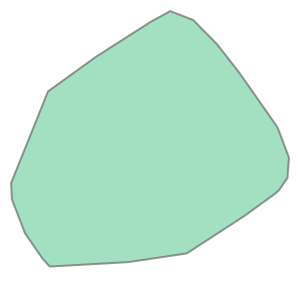

In [7]:
convex_hull = edges.unary_union.convex_hull
convex_hull

In [8]:
stats = osmnx.basic_stats(graph, area=convex_hull.area)
stats

{'n': 1461,
 'm': 3146,
 'k_avg': 4.306639288158795,
 'edge_length_total': 101193.84999999986,
 'edge_length_avg': 32.16587730451362,
 'streets_per_node_avg': 2.620123203285421,
 'streets_per_node_counts': {0: 0, 1: 436, 2: 19, 3: 692, 4: 293, 5: 20, 6: 1},
 'streets_per_node_proportions': {0: 0.0,
  1: 0.29842573579739906,
  2: 0.013004791238877482,
  3: 0.4736481861738535,
  4: 0.2005475701574264,
  5: 0.013689253935660506,
  6: 0.0006844626967830253},
 'intersection_count': 1025,
 'street_length_total': 62755.4369999998,
 'street_segment_count': 1874,
 'street_length_avg': 33.487426360725614,
 'circuity_avg': 1.0459705326096647,
 'self_loop_proportion': 0.0016008537886872999,
 'node_density_km': 844.355626754783,
 'intersection_density_km': 592.3781775658128,
 'edge_density_km': 58482.95457938356,
 'street_density_km': 36268.24527064006}

<h1> Shortest path analysis </h1>
Let’s now calculate the shortest path between two points using osmnx.shortest_path().

<h2> Origin and destination points </h2>
First we need to specify the source and target locations for our route. If you are familiar with the Kamppi area, you can specify a custom placename as a source location. Or, you can follow along and choose these points as the origin and destination in the analysis:

"Maria 01, Helsinki": a startup hub in a former hospital area.

"ruttopuisto", a park. The park’s official name is ’Vanha kirkkopuisto’, but Nominatim is also able to geocode the nickname.

We could figure out the coordinates for these locations manually, and create shapely.geometry.Points based on the coordinates. However, if we would have more than just two points, that would quickly become a chore. Instead, we can use OSMnx to geocode the locations.

Remember to transform the origin and destination points to the same reference system as the network data.

In [9]:
origin = (
    osmnx.geocode_to_gdf("Maria 01, Helsinki")  # fetch geolocation
    .to_crs(edges.crs)  # transform to UTM
    .at[0, "geometry"]  # pick geometry of first row
    .centroid  # use the centre point
)

destination = (
    osmnx.geocode_to_gdf("ruttopuisto")
    .to_crs(edges.crs)
    .at[0, "geometry"]
    .centroid
)

We now have shapely.geometry.Points representing the origin and destination locations for our network analysis. In a next step, we need find these points on the routable network before the final routing.

<h1> Nearest node </h1>
To route on the network, we first have to find a starting point and endpoint that is part of the network. Use [osmnx.distance.nearest_nodes()](https://osmnx.readthedocs.io/en/stable/osmnx.html#osmnx.distance.nearest_nodes) to return the nearest node’s ID:

In [10]:
origin_node_id = osmnx.nearest_nodes(graph, origin.x, origin.y)
origin_node_id

319719983

In [11]:
destination_node_id = osmnx.nearest_nodes(graph, destination.x, destination.y)
destination_node_id

2195109761

<h1> Routing </h1>
Now we are ready for routing and to find the shortest path between the origin and target locations. We will use osmnx.shortest_path().

The function accepts three mandatory parameters: a graph, an origin node id, and a destination node id, and two optional parameters: weight can be set to consider a different cost impedance than the length of the route, and cpus controls parallel computation of many routes.

In [12]:
# Find the shortest path between origin and destination
route = osmnx.shortest_path(graph, origin_node_id, destination_node_id)
route

[319719983,
 11702007434,
 1382316822,
 1382316829,
 1382316852,
 5464887863,
 1382320461,
 5154747161,
 1378064352,
 1372461709,
 1372441203,
 3205236795,
 3205236793,
 8244768393,
 60278325,
 56115897,
 60072524,
 7699019923,
 7699019916,
 7699019908,
 7699019903,
 267117319,
 1897461604,
 724233143,
 724233128,
 267117317,
 846597945,
 846597947,
 2037356632,
 1547012339,
 569742461,
 1372441189,
 4524927399,
 298372061,
 7702074840,
 7702074833,
 60170471,
 8856704555,
 3227176325,
 7676757030,
 8856704573,
 7676756995,
 8856704588,
 1377211668,
 7676890497,
 1377211666,
 292859324,
 25291565,
 2195109761]

In [13]:
type(route)

list

As a result we get a list of all the nodes that are along the shortest path.

We could extract the locations of those nodes from the nodes GeoDataFrame and create a LineString presentation of the points, but luckily, OSMnx can do that for us and we can plot shortest path by using plot_graph_route() function:

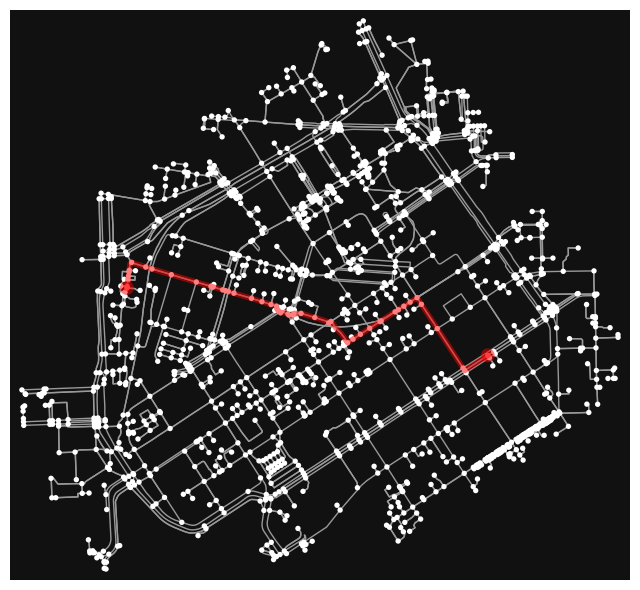

In [14]:
# Plot the shortest path
fig, ax = osmnx.plot_graph_route(graph, route)


Nice! Now we have the shortest path between our origin and target locations. Being able to analyze shortest paths between locations can be valuable information for many applications. Here, we only analyzed the shortest paths based on distance but quite often it is more useful to find the optimal routes between locations based on the travelled time. Here, for example we could calculate the time that it takes to cross each road segment by dividing the length of the road segment with the speed limit and calculate the optimal routes by taking into account the speed limits as well that might alter the result especially on longer trips than here.

In [15]:
# Get the nodes along the shortest path
route_nodes = nodes.loc[route]
route_nodes

,y,x,street_count,lon,lat,highway,ref,geometry
osmid,,,,,,,,
319719983,6.671816e+06,384706.296089,3,24.922273,60.166932,NaN,NaN,POINT (384706.296 6671815.989)
11702007434,6.671820e+06,384706.910549,3,24.922282,60.166971,NaN,NaN,POINT (384706.911 6671820.338)
1382316822,6.671839e+06,384709.579017,4,24.922319,60.167142,NaN,NaN,POINT (384709.579 6671839.311)
1382316829,6.671850e+06,384711.044607,3,24.922339,60.167236,NaN,NaN,POINT (384711.045 6671849.707)
1382316852,6.671861e+06,384712.504583,3,24.922359,60.167338,NaN,NaN,POINT (384712.505 6671860.984)
5464887863,6.671865e+06,384713.220293,3,24.922370,60.167377,NaN,NaN,POINT (384713.220 6671865.374)
1382320461,6.671887e+06,384719.671826,3,24.922473,60.167575,NaN,NaN,POINT (384719.672 6671887.215)
5154747161,6.671874e+06,384758.946564,3,24.923188,60.167471,NaN,NaN,POINT (384758.947 6671874.411)
1378064352,6.671869e+06,384776.322613,3,24.923504,60.167428,NaN,NaN,POINT (384776.323 6671869.117)


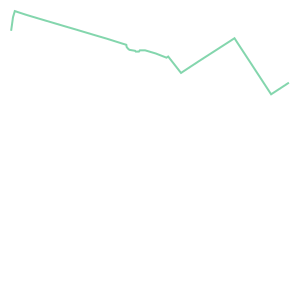

In [17]:
import shapely.geometry

# Create a geometry for the shortest path
route_line = shapely.geometry.LineString(
    list(route_nodes.geometry.values)
)
route_line

Now we have the route as a LineString geometry.

Let’s make a GeoDataFrame out of it having some useful information about our route such as a list of the osmids that are part of the route and the length of the route.

In [18]:
import geopandas

route_geom = geopandas.GeoDataFrame(
    {
        "geometry": [route_line],
        "osm_nodes": [route],
    },
    crs=edges.crs
)

# Calculate the route length
route_geom["length_m"] = route_geom.length

route_geom.head()

,geometry,osm_nodes,length_m
0,"LINESTRING (384706.296 6671815.989, 384706.911...","[319719983, 11702007434, 1382316822, 138231682...",1291.324641


Now we have a GeoDataFrame that we can save to disk. Let’s still confirm that everything is ok by plotting our route on top of our street network and some buildings, and plot also the origin and target points on top of our map.

Download buildings:

In [19]:
buildings = osmnx.geometries_from_place(
    PLACE_NAME,
    {
        "building" : True
    }
).to_crs(edges.crs)

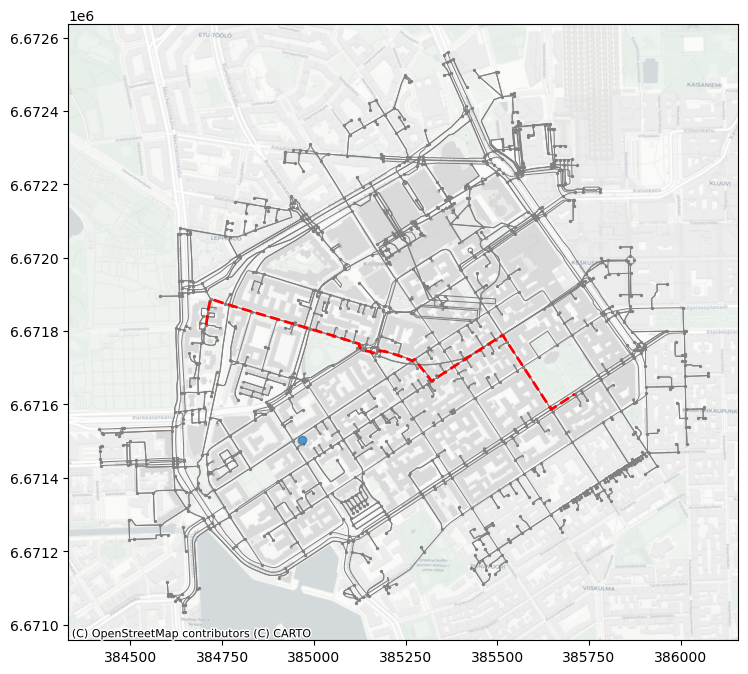

In [20]:
import contextily
import matplotlib.pyplot

fig, ax = matplotlib.pyplot.subplots(figsize=(12,8))

# Plot edges and nodes
edges.plot(ax=ax, linewidth=0.75, color='gray')
nodes.plot(ax=ax, markersize=2, color='gray')

# Add buildings
ax = buildings.plot(ax=ax, facecolor='lightgray', alpha=0.7)

# Add the route
ax = route_geom.plot(ax=ax, linewidth=2, linestyle='--', color='red')

# Add basemap
contextily.add_basemap(ax, crs=buildings.crs, source=contextily.providers.CartoDB.Positron)

In [21]:
edges.head()

osmid  oneway  \
u          v          key                                                    
25216594   1372425721 0                                   23717777    True   
           1372425714 0                                   23856784    True   
1372425721 25290781   0                                   29191566   False   
           60070671   0          [930820929, 930820930, 654270815]   False   
1372425714 25238874   0    [78537378, 8169098, 29081876, 78537375]    True   

                            lanes            name   highway maxspeed reversed  \
u          v          key                                                       
25216594   1372425721 0         2   Porkkalankatu   primary       40    False   
           1372425714 0         2  Mechelininkatu   primary       40    False   
1372425721 25290781   0       NaN             NaN  cycleway      NaN     True   
           60070671   0       NaN             NaN  cycleway      NaN    False   
1372425714 25238874   0    [3, 2]  Mechelininkatu   primary       40    False   

                            length  \
u          v          key            
25216594   1372425721 0     10.404   
           1372425714 0     40.885   
1372425721 25290781   0    228.587   
           60070671   0     41.006   
1372425714 25238874   0     85.741   

                                                                    geometry  \
u          v          key                                                      
25216594   1372425721 0    LINESTRING (384631.322 6671580.071, 384620.884...   
           1372425714 0    LINESTRING (384631.322 6671580.071, 384624.750...   
1372425721 25290781   0    LINESTRING (384620.884 6671579.965, 384621.184...   
           60070671   0    LINESTRING (384620.884 6671579.965, 384620.720...   
1372425714 25238874   0    LINESTRING (384624.179 6671539.986, 384623.768...   

                          junction bridge width service tunnel access  
u          v          key                                              
25216594   1372425721 0        NaN    NaN   NaN     NaN    NaN    NaN  
           1372425714 0        NaN    NaN   NaN     NaN    NaN    NaN  
1372425721 25290781   0        NaN    NaN   NaN     NaN    NaN    NaN  
           60070671   0        NaN    NaN   NaN     NaN    NaN    NaN  
1372425714 25238874   0        NaN    NaN   NaN     NaN    NaN    NaN

In [22]:
# Columns with invalid values
problematic_columns = [
    "osmid",
    "lanes",
    "name",
    "highway",
    "width",
    "maxspeed",
    "reversed",
    "junction",
    "bridge",
    "tunnel",
    "access",
    "service",
    
]

#  convert selected columns to string format
edges[problematic_columns] = edges[problematic_columns].astype(str)

In [23]:
route_geom["osm_nodes"] = route_geom["osm_nodes"].astype(str)


In [24]:
import pathlib
NOTEBOOK_PATH = pathlib.Path().resolve()
DATA_DIRECTORY = NOTEBOOK_PATH / "static" / "data"

In [25]:
# Save one layer after another
output_gpkg = DATA_DIRECTORY / "OSM_Kamppi.gpkg"

edges.to_file(output_gpkg, layer="streets")
route_geom.to_file(output_gpkg, layer="route")
nodes.to_file(output_gpkg, layer="nodes")
#buildings[['geometry', 'name', 'addr:street']].to_file(output_gpkg, layer="buildings")
display(buildings.describe())
display(buildings)

/Users/crwlyfr2/opt/anaconda3/envs/autogis/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:127: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


,ele,geometry,amenity,operator,wheelchair,source,access,addr:housenumber,addr:street,addr:unit,...,lippakioski,toilets:disposal,unisex,covered,area,leisure,ways,type,electrified,nohousenumber
count,1,455,18,3,14,18,8,194,196,21,...,1,1,1,1,1,1,36,36,1,2
unique,1,455,12,3,3,4,2,65,36,21,...,1,1,1,1,1,1,36,1,1,1
top,5,POINT (384966.6609617978 6671503.785973044),place_of_worship,Nice Bike Oy,yes,survey,private,2-10,Kalevankatu,K,...,yes,flush,yes,yes,yes,sauna,"[22665612, 22664922]",multipolygon,yes,yes
freq,1,1,4,1,10,9,7,14,26,1,...,1,1,1,1,1,1,1,36,1,2


ele  \
element_type osmid              
node         11711721042  NaN   
way          8035238      NaN   
             8042297      NaN   
             14797170     NaN   
             14797171     NaN   
...                       ...   
relation     8092998      NaN   
             8280536      NaN   
             8525159      NaN   
             8525161      NaN   
             8535506      NaN   

                                                                   geometry  \
element_type osmid                                                            
node         11711721042                     POINT (384966.661 6671503.786)   
way          8035238      POLYGON ((385459.650 6672184.469, 385456.356 6...   
             8042297      POLYGON ((385104.154 6671916.693, 385101.584 6...   
             14797170     POLYGON ((384815.326 6671762.710, 384815.792 6...   
             14797171     POLYGON ((384797.759 6671853.253, 384798.253 6...   
...                                                                     ...   
relation     8092998      POLYGON ((384747.465 6671811.996, 384744.270 6...   
             8280536      POLYGON ((384839.007 6671934.815, 384839.485 6...   
             8525159      POLYGON ((385494.804 6672166.709, 385494.902 6...   
             8525161      POLYGON ((385486.225 6672173.653, 385486.717 6...   
             8535506      POLYGON ((385481.130 6672167.861, 385482.372 6...   

                         amenity          operator wheelchair  source access  \
element_type osmid                                                             
node         11711721042     NaN      Nice Bike Oy        NaN     NaN    NaN   
way          8035238         NaN               NaN        NaN     NaN    NaN   
             8042297         NaN               NaN        NaN     NaN    NaN   
             14797170        NaN  City of Helsinki        NaN  survey    NaN   
             14797171        NaN               NaN        NaN  survey    NaN   
...                          ...               ...        ...     ...    ...   
relation     8092998         NaN               NaN        NaN     NaN    NaN   
             8280536         NaN               NaN        NaN     NaN    NaN   
             8525159         NaN               NaN        NaN     NaN    NaN   
             8525161         NaN               NaN        NaN     NaN    NaN   
             8535506         NaN               NaN        NaN     NaN    NaN   

                         addr:housenumber      addr:street addr:unit  ...  \
element_type osmid                                                    ...   
node         11711721042               46      Eerikinkatu       NaN  ...   
way          8035238                22-24  Mannerheimintie       NaN  ...   
             8042297                    2   Runeberginkatu       NaN  ...   
             14797170                  10  Lapinlahdenkatu       NaN  ...   
             14797171                 NaN              NaN       NaN  ...   
...                                   ...              ...       ...  ...   
relation     8092998                   16  Lapinlahdenkatu       NaN  ...   
             8280536                   38       Malminkatu       NaN  ...   
             8525159                  NaN              NaN       NaN  ...   
             8525161                  NaN              NaN       NaN  ...   
             8535506                  NaN              NaN       NaN  ...   

                         lippakioski toilets:disposal unisex covered area  \
element_type osmid                                                          
node         11711721042         NaN              NaN    NaN     NaN  NaN   
way          8035238             NaN              NaN    NaN     NaN  NaN   
             8042297             NaN              NaN    NaN     NaN  NaN   
             14797170            NaN              NaN    NaN     NaN  NaN   
             14797171            NaN              NaN    NaN   